In [ ]:
!pip install transformers
!pip install tokenizers
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
##!pip install -q --upgrade ipython
##!pip install -q --upgrade ipykernel

##**Model**: Feed BERT embedding to BiLSTM 

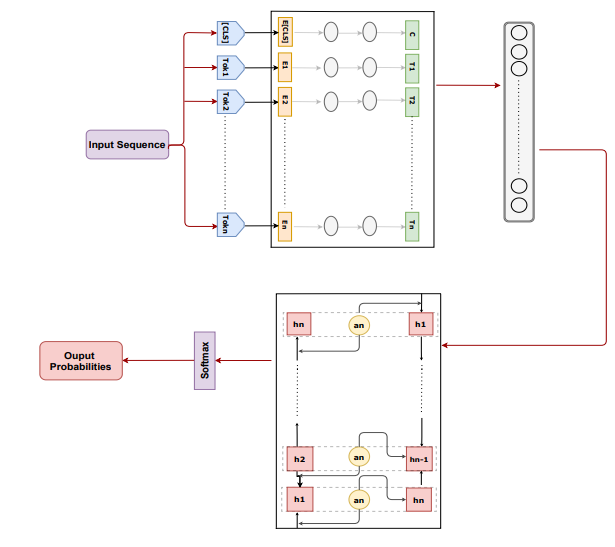

In [ ]:
import os
import re
import json
import string
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras import metrics, optimizers, losses
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig

In [ ]:
#import os
from google.colab import  drive
drive.mount('/drive')
data_csv = pd.read_csv("/drive/My Drive/ner_df1.csv", encoding="latin1").fillna(method="ffill")

Mounted at /drive


In [ ]:
print("unique words; ",data_csv["Word"].nunique())
print("unique tags; ",data_csv["Tag"].nunique())

unique words;  112265
unique tags;  23


In [ ]:
data_csv.head()

,Unnamed: 0,Sentence #,Word,Tag
0,0,1,The,O
1,1,1,Google,B-ExploitTargetObject
2,2,1,hacks,O
3,3,1,Operation,B-COMPAIGN
4,4,1,Aurora,I-COMPAIGN


In [ ]:
import sklearn.model_selection
tags=data_csv['Tag'].unique().tolist()
train_dataset, test_dataset = sklearn.model_selection.train_test_split(data_csv, train_size=0.8, test_size=0.2)

In [ ]:
train_dataset.to_csv('/drive/My Drive/train_dataset.csv')

In [ ]:
test_dataset.to_csv('/drive/My Drive/test_dataset.csv')

In [ ]:
max_len = 75
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
configuration = BertConfig()


slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

slow_tokenizer.save_pretrained(save_path)

tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False,
                                                            reduction=tf.keras.losses.Reduction.NONE)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### **Needed functions for model implementation**

This section contains the following functions: 

- masked_ce_loss()
- create_model()
- process_csv()
- create_inputs_targets()

In [ ]:
def masked_ce_loss(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 18))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
def create_model(num_tags):
    
    encoder = TFBertModel.from_pretrained("bert-base-uncased")
    
    encoder.trainable = False
 
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    
    inputs_berts = [input_ids, token_type_ids, attention_mask]
    
    embedding = encoder(inputs_berts)[0]
    
    bi_lstm = layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(max_len // 2, 
                                                             return_sequences=True),
                                                             name='bilstm')(embedding)

    dropout = layers.TimeDistributed(layers.Dropout(0.3))(bi_lstm)

    dense_layer = layers.TimeDistributed(layers.Dense(max_len,
                                                      activation='relu',
                                                      name='last_dense'))(dropout)

    output = layers.Dense(num_tags + 1,
                          activation="softmax",
                          name='predictions')(dense_layer)

    model = models.Model(inputs=inputs_berts, outputs=output)

    model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss=[masked_ce_loss],
                  metrics=[metrics.SparseCategoricalAccuracy('accuracy')])
    
    return model


In [ ]:
def process_csv(data_path):

    df = pd.read_csv(data_path, encoding="latin-1")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")

    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])

    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values

    return sentences, tag, enc_tag


In [ ]:
def create_inputs_targets(data_csv):

    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "tags": []
    }

    sentences, tags, tag_encoder = process_csv(data_csv)
    
    for sentence, tag in zip(sentences, tags):

        input_ids = []
        target_tags = []

        for idx, word in enumerate(sentence):

            ids = tokenizer.encode(word, add_special_tokens=False)
            input_ids.extend(ids.ids)
            num_tokens = len(ids)
            target_tags.extend([tag[idx]] * num_tokens)
        
        
        # Pad truncate
        input_ids = input_ids[:max_len - 2]
        target_tags = target_tags[:max_len - 2]

        input_ids = [101] + input_ids + [102]
        target_tags = [16] + target_tags + [16]
        token_type_ids = [0] * len(input_ids)
        attention_mask = [1] * len(input_ids)
        padding_len = max_len - len(input_ids)

        input_ids = input_ids + ([0] * padding_len)
        attention_mask = attention_mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_tags = target_tags + ([17] * padding_len)
        
        dataset_dict["input_ids"].append(input_ids)
        dataset_dict["token_type_ids"].append(token_type_ids)
        dataset_dict["attention_mask"].append(attention_mask)
        dataset_dict["tags"].append(target_tags)
        
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]

    y = dataset_dict["tags"]

    return x, y, tag_encoder

### **Splitting data to train/test**

In [ ]:
num_tags = train_dataset["Tag"].nunique()

x_train, y_train, tag_encoder = create_inputs_targets('/drive/My Drive/train_dataset.csv')

In [ ]:
x_test, y_test, tag_encoder = create_inputs_targets('/drive/My Drive/test_dataset.csv')

###***Create Model***

In [ ]:
model = create_model(num_tags)
    
model.summary()


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 75)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 75)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]',            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.fit(
    x_train,
    y_train,
    epochs=20,
    verbose=1,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/20
1363/1363 [==============================] - 239s 166ms/step - loss: 0.2179 - accuracy: 0.9392 - val_loss: 0.9927 - val_accuracy: 0.7704
Epoch 2/20
1363/1363 [==============================] - 224s 164ms/step - loss: 0.1549 - accuracy: 0.9481 - val_loss: 1.0135 - val_accuracy: 0.7698
Epoch 3/20
1363/1363 [==============================] - 224s 164ms/step - loss: 0.1422 - accuracy: 0.9501 - val_loss: 1.0153 - val_accuracy: 0.7722
Epoch 4/20
1363/1363 [==============================] - 224s 164ms/step - loss: 0.1354 - accuracy: 0.9512 - val_loss: 1.0334 - val_accuracy: 0.7729
Epoch 5/20
1363/1363 [==============================] - 224s 164ms/step - loss: 0.1297 - accuracy: 0.9524 - val_loss: 1.0627 - val_accuracy: 0.7662
Epoch 6/20
1363/1363 [==============================] - 224s 164ms/step - loss: 0.1258 - accuracy: 0.9533 - val_loss: 1.1637 - val_accuracy: 0.7717
Epoch 7/20
1363/1363 [==============================] - 224s 164ms/step - loss: 0.1231 - accuracy: 0.9538 - val_

In [ ]:
from future.utils import iteritems

tags = list(set(data_csv["Tag"].values))
number_tags = len(tags)

tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: w for w, i in iteritems(tag2idx)}

In [ ]:
y_pred = model.predict(x_test)
pred_tags = np.argmax(y_pred,2)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

m = MultiLabelBinarizer().fit(y_test)

In [ ]:
f1_score(m.transform(y_test),
         m.transform(np.argmax(y_pred,axis=2)), average='samples')

In [ ]:
print(classification_report(m.transform(y_test), 
                            m.transform(np.argmax(y_pred,axis=2)),
                            labels=list(idx2tag.keys()), 
                            target_names=list(idx2tag.values())))

                          precision    recall  f1-score   support

              B-COMPAIGN       0.22      0.21      0.22      2528
I-MALWARECHARACTERISTICS       0.17      0.50      0.25       596
             B-INDICATOR       0.48      0.60      0.54      1854
               I-PRODUCT       0.15      0.18      0.16       616
                  B-DATE       0.13      0.34      0.19       966
B-MALWARECHARACTERISTICS       0.14      0.20      0.17       255
                   I-LOC       0.44      0.73      0.55      1658
               B-PRODUCT       0.38      0.41      0.39      5589
               I-MALWARE       0.58      0.24      0.34      2435
                  I-DATE       0.41      0.33      0.36      1685
                   B-LOC       0.35      0.14      0.20       385
           I-INFORMATION       0.19      0.06      0.09      1601
         B-VULNERABILITY       0.05      0.08      0.06       132
             I-INDICATOR       0.49      0.35      0.41      1410
         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Metric seqeval : Evaluation

seqeval is a Python framework for sequence labeling evaluation. seqeval can evaluate the performance of chunking tasks such as named-entity recognition, part-of-speech tagging, semantic role labeling and so on.

This is well-tested by using the Perl script conlleval, which can be used for measuring the performance of a system that has processed the CoNLL-2000 shared task data.

seqeval supports following formats: IOB1 IOB2 IOE1 IOE2 IOBES

In [ ]:
from seqeval.metrics import classification_report, f1_score

In [ ]:
np.argmax(y_pred,axis=2)

array([[16, 22, 22, ..., 17, 17, 17],
       [16, 22, 22, ..., 17, 17, 17],
       [16, 22, 22, ..., 17, 17, 17],
       ...,
       [16, 22, 22, ..., 22, 22, 16],
       [16, 22, 22, ..., 22, 22, 16],
       [16, 22, 22, ..., 22, 22, 16]])

In [ ]:
len(y_test[0])

75

In [ ]:
T=[idx2tag[j] for i in y_test for j in i ]
P=[idx2tag[j] for i in np.argmax(y_pred,axis=2) for j in i ]

In [ ]:
idx2tag

{0: 'B-COMPAIGN',
 1: 'I-MALWARECHARACTERISTICS',
 2: 'B-INDICATOR',
 3: 'I-PRODUCT',
 4: 'B-DATE',
 5: 'B-MALWARECHARACTERISTICS',
 6: 'I-LOC',
 7: 'B-PRODUCT',
 8: 'I-MALWARE',
 9: 'I-DATE',
 10: 'B-LOC',
 11: 'I-INFORMATION',
 12: 'B-VULNERABILITY',
 13: 'I-INDICATOR',
 14: 'I-VULNERABILITY',
 15: 'B-ATTACKER',
 16: 'I-ExploitTargetObject',
 17: 'I-COMPAIGN',
 18: 'B-MALWARE',
 19: 'I-ATTACKER',
 20: 'B-ExploitTargetObject',
 21: 'B-INFORMATION',
 22: 'O'}

In [ ]:
print(f1_score([T], [P]))

0.6079920491825744


In [ ]:
print(classification_report([T], [P]))

                        precision    recall  f1-score   support

              ATTACKER       0.15      0.03      0.05     13913
              COMPAIGN       0.91      0.90      0.91     49117
                  DATE       0.21      0.34      0.26      6893
   ExploitTargetObject       0.99      0.98      0.99     90456
             INDICATOR       0.58      0.67      0.62      4797
           INFORMATION       0.04      0.00      0.01      8471
                   LOC       0.38      0.45      0.42      3353
               MALWARE       0.23      0.01      0.01     44897
MALWARECHARACTERISTICS       0.11      0.21      0.15      1469
                 Other       0.53      0.64      0.58    569951
               PRODUCT       0.29      0.31      0.30     13855
         VULNERABILITY       0.09      0.11      0.10       687

             micro avg       0.59      0.63      0.61    807859
             macro avg       0.38      0.39      0.37    807859
          weighted avg       0.57     